In [3]:
import matplotlib.pyplot as plt
from util import to_onehot, moving_average, Agent
import gym

plt.style.use('fivethirtyeight')
%matplotlib inline

In [28]:
env = gym.make('CartPole-v0')

SAMPLE_BATCH_SIZE = 32
OBS_SPACE = 4
ACTION_SPACE = env.action_space.n
N_EPISODES = 2000

# scenario 1: single agent training
for each s1, the agent learns q-values for s2. it doesnt learn policy - the agent's decision to select the action that leads to s2 with the greatest q-value is hardcoded as argmax.

the original atari approach used a single DQN agent.

In [29]:
from agent import Agent
agent = Agent(OBS_SPACE, ACTION_SPACE)

In [30]:
num_steps = []

for episode in range(N_EPISODES):
    s1 = env.reset()
    done = False
    steps = 0
    
    while not done:
        
        # propose an action
        a = agent.act(s1.reshape(-1,4))
        
        # what are the consequences of taking that action?
        s2, r, done, i = env.step(a)
        
        # store memories for experience replay (prevents catastrophic forgetting)
        agent.remember(s1.reshape(-1,4), a, r, s2.reshape(-1,4), done)
        
        # move to next state
        s1 = s2
        steps += 1
        
    agent.replay(SAMPLE_BATCH_SIZE)
    num_steps.append(steps)
    
    if episode % 100 == 0:
        print episode, " /", steps

0  / 19
100  / 17
200  / 60
300  / 96
400  / 67
500  / 151
600  / 144
700  / 110
800  / 187
900  / 170
1000  / 200
1100  / 200
1200  / 200
1300  / 199
1400  / 10
1500  / 200
1600  / 148
1700  / 200
1800  / 85
1900  / 200


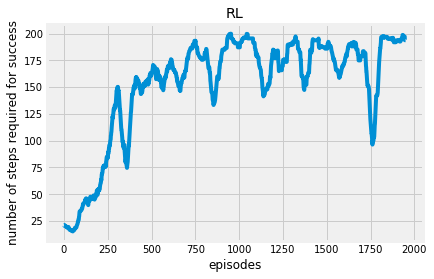

In [32]:
plt.plot(moving_average(num_steps, 50))
plt.ylabel("number of steps required for success")
plt.xlabel("episodes")
plt.title("RL")

# approach 2: actor/critic model

a critic network (aka value network) predicts a single value for a specific location.

the value network will place higher values near the final winning position (and low values in the "hole" positions). it will place the higest value on the winning final position.

the value network expresses the the most efficient path to the policy network. it is no different from a critic telling an actor how to act (and similarly, it is up to the actor to follow the critic's suggestions.)

the actor (aka policy network) predicts the best action from the current state. the best action is quantified as (1) reward + (2) discounted next value - (3) predicted value. the actor will no longer select the < action/next-state > with the highest value; instead it will select the < action/next-state > that results in the greatest change in value.

* http://www.rage.net/~greg/2016-07-05-ActorCritic-with-OpenAI-Gym.html

### critic

In [36]:
from critic import Critic
import math
import numpy as np

In [37]:
critic = Critic(OBS_SPACE, ACTION_SPACE)
gamma = 0.9

In [42]:
for episode in range(N_EPISODES):
    
    s1 = env.reset()
    done = False
    steps = 0
    
    while not done:
        
        # ask critic to predict value for current state        
        orig_val = critic.predict(s1.reshape(-1,4))
        
        # take an action
        a = agent.act(s1.reshape(-1,4))
        
        # what are the consequences of taking that action?
        s2, r, done, i = env.step(a)
        
        # get critic's prediction on next state
        new_val = critic.predict(s2.reshape(-1,4))
        
        # determine target value
        if not done:
            target = (gamma * new_val)
        else:
            target = (gamma * r)  # max value is discounted reward at final location
        
        # positions near final location will propagate backwards
        best_val = max((orig_val*gamma), target)
        
        # each state is encoded with its "best" target value
        # the target value is equal to the discounted next value
        # we dont care which action led to this value!
        critic.remember((s1.reshape(-1,4), best_val))
        
        # if terminal, append another replay for final location (otherwise final loc will never be recorded)
        if done:
            critic.remember((s2.reshape(-1,4), r))
        
        # move on to next state and continue
        s1 = s2
        steps += 1
    
    critic.replay(SAMPLE_BATCH_SIZE)
    
    if episode % 500 == 0:
        print (episode, steps)

(0, 200)
(500, 200)
(1000, 200)
(1500, 200)


## actor

In [43]:
from actor import Actor
actor = Actor(OBS_SPACE, ACTION_SPACE)

In [55]:
n_steps = []

for episode in range(1000):
    
    s1 = env.reset()
    done = False
    steps = 0
    
    while not done:
        # get value for current state from critic
        orig_val = critic.predict(s1.reshape(-1,4))
        
        # propose an action
        a = agent.act(s1.reshape(-1,4))
        
        # what are the consequences of taking that action?
        s2, r, done, i = env.step(a)
        
        # get value for next state from critic
        new_val = critic.predict(s2.reshape(-1,4))
        
        # The actor is updated
        # by using the difference of the value the critic
        # placed on the old state vs. the value the critic
        # places on the new state.. encouraging the actor
        # to move into more valuable states.
        
        # actor learns to predict a set of actor deltas
        actor_delta = new_val - orig_val                
        actor.remember([s1.reshape(-1,4), a, actor_delta])
    
        # move on to next state and continue
        s1 = s2
        steps += 1
    
        # TODO: inside while loop or not?
    actor.replay()
    n_steps.append(steps)
    
    if episode % 100 == 0:
        print (episode, steps)

(0, 200)
(100, 200)
(200, 200)
(300, 200)
(400, 200)
(500, 200)
(600, 200)
(700, 200)
(800, 200)
(900, 200)


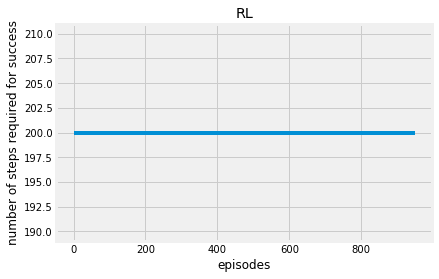

In [56]:
plt.plot(moving_average(n_steps, 50))
plt.ylabel("number of steps required for success")
plt.xlabel("episodes")
plt.title("RL")